In [2]:
import pandas as pd  # Import Pandas for data manipulation and analysis
import numpy as np  # Import NumPy for numerical computations
import os  # Import OS module for interacting with the operating system (e.g., file paths)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Import metrics for evaluating classification performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Import classification metrics
from imblearn.over_sampling import SMOTE  # Import SMOTE for handling imbalanced datasets
import random  # Import random for generating random numbers
import matplotlib.pyplot as plt  # Import Matplotlib for plotting graphs
from scipy.linalg import svd  # Import SVD (Singular Value Decomposition) for matrix factorization
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier for classification
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting datasets

class DMD:
    def __init__(self, rank=None):  # Constructor for DMD class, with optional rank parameter
        self.rank = rank  # Set the rank for dimensionality reduction
        self.modes = None  # Initialize modes (eigenvectors) to None
        self.eigenvalues = None  # Initialize eigenvalues to None
        self.dynamics = None  # Initialize dynamics (time evolution) to None

    def fit(self, X):  # Method to fit DMD to the input data X
        X1 = X[:, :-1]  # Create matrix X1 (all columns except the last)
        X2 = X[:, 1:]  # Create matrix X2 (all columns except the first)
        U, S, Vh = svd(X1, full_matrices=False)  # Perform SVD on X1

        if self.rank:  # If rank is specified, truncate SVD components
            U = U[:, :self.rank]  # Truncate U to the specified rank
            S = np.diag(S[:self.rank])  # Truncate singular values and convert to diagonal matrix
            Vh = Vh[:self.rank, :]  # Truncate Vh to the specified rank

        A_tilde = U.T @ X2 @ Vh.T @ np.linalg.inv(S)  # Compute the reduced matrix A_tilde
        eigvals, eigvecs = np.linalg.eig(A_tilde)  # Compute eigenvalues and eigenvectors of A_tilde
        self.modes = U @ eigvecs  # Compute DMD modes
        self.eigenvalues = eigvals  # Store eigenvalues
        self.dynamics = np.linalg.pinv(self.modes) @ X1[:, 0]  # Compute time dynamics

    def reconstruct(self, timesteps):  # Method to reconstruct the data for a given number of timesteps
        time_dynamics = np.array([self.eigenvalues**i for i in range(timesteps)])  # Compute time dynamics
        return self.modes @ np.diag(self.dynamics) @ time_dynamics.T  # Reconstruct the data


def apply_dmd_to_pmu_data(data, snr):  # Function to apply DMD to PMU data
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Extract numeric columns
    X = data[numeric_columns].T.values  # Transpose and convert numeric data to a NumPy array
    dmd = DMD(rank=20)  # Initialize DMD with rank 5
    dmd.fit(X)  # Fit DMD to the data
    reconstructed = dmd.reconstruct(X.shape[1])  # Reconstruct the data

    # Compute reconstruction error
    error = np.linalg.norm(X - reconstructed, axis=0)  # Calculate reconstruction error for each timestep
    anomaly_threshold = np.percentile(error, 95)  # Set anomaly threshold as the 95th percentile of errors
    anomaly_labels = (error > anomaly_threshold).astype(int)  # Label anomalies (1 if error > threshold, else 0)

    # Add predictions to data
    data['DMD_Label'] = anomaly_labels  # Add anomaly labels to the dataset
    accuracy = accuracy_score(data['True_Label'], data['DMD_Label'])  # Calculate accuracy
    print(f"DMD-based anomaly detection accuracy at SNR {snr}: {accuracy:.2f}")  # Print accuracy

    return data, accuracy  # Return the dataset with labels and accuracy


def process_with_dmd(input_dir, output_dir, snr_values, anomalies):  # Function to process data with DMD
    snr_accuracy = {}  # Dictionary to store accuracy for each SNR value

    for snr in snr_values:  # Loop through each SNR value
        print(f"\nProcessing with SNR: {snr} dB using DMD")  # Print current SNR
        accuracies = []  # List to store accuracies for each file

        for file_name in os.listdir(input_dir):  # Loop through each file in the input directory
            if file_name.endswith('.csv'):  # Check if the file is a CSV
                file_path = os.path.join(input_dir, file_name)  # Construct full file path
                data = read_csv(file_path)  # Read the CSV file
                noisy_data = add_noise(data, data.select_dtypes(include=[np.number]).columns.tolist(), snr)  # Add noise
                anomalous_data, _ = introduce_anomalies(noisy_data, anomalies)  # Introduce anomalies
                preprocessed_data = preprocess_data(anomalous_data)  # Preprocess the data
                balanced_data = balance_data(preprocessed_data)  # Balance the dataset
                dmd_data, accuracy = apply_dmd_to_pmu_data(balanced_data, snr)  # Apply DMD and get accuracy
                accuracies.append(accuracy)  # Append accuracy to the list

        snr_accuracy[snr] = np.mean(accuracies)  # Store the mean accuracy for the current SNR

    return snr_accuracy  # Return the dictionary of SNR vs. accuracy

def process_all_files(input_dir, output_dir, snr_values, anomalies):  # Define a function to process all files in a directory
    snr_accuracy = {}  # Dictionary to store accuracy for each SNR value
    snr_anomalies = {}  # Dictionary to store the total number of anomalies introduced for each SNR value

    for snr in snr_values:  # Loop through each SNR value
        print(f"\nProcessing with SNR: {snr} dB")  # Print the current SNR value being processed
        if not os.path.exists(output_dir):  # Check if the output directory exists
            os.makedirs(output_dir)  # Create the output directory if it doesn't exist

        aggregate_accuracy = []  # List to store accuracy values for all files at the current SNR
        total_anomalies = 0  # Counter to store the total number of anomalies introduced at the current SNR

        for file_name in os.listdir(input_dir):  # Loop through each file in the input directory
            if file_name.endswith('.csv'):  # Check if the file is a CSV file
                file_path = os.path.join(input_dir, file_name)  # Construct the full file path
                data = read_csv(file_path)  # Read the CSV file into a DataFrame
                numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Extract numeric columns

                noisy_data = add_noise(data, numeric_columns, snr)  # Add noise to the numeric columns based on SNR
                anomalous_data, anomaly_count = introduce_anomalies(noisy_data, anomalies)  # Introduce anomalies
                total_anomalies += anomaly_count  # Update the total number of anomalies
                preprocessed_data = preprocess_data(anomalous_data)  # Preprocess the data (e.g., impute missing values)
                balanced_data = balance_data(preprocessed_data)  # Balance the dataset (e.g., using SMOTE)
                simulated_data = simulate_predictions(balanced_data, snr)  # Simulate predictions with mislabeling
                accuracy = evaluate_classification(simulated_data)['accuracy']  # Evaluate classification accuracy
                aggregate_accuracy.append(accuracy)  # Append the accuracy to the aggregate list

        snr_accuracy[snr] = np.mean(aggregate_accuracy)  # Store the mean accuracy for the current SNR
        snr_anomalies[snr] = total_anomalies  # Store the total number of anomalies for the current SNR

    return snr_accuracy, snr_anomalies  # Return the dictionaries containing SNR vs. accuracy and SNR vs. anomalies

def plot_accuracy_vs_snr(snr_accuracy):  # Define a function named `plot_accuracy_vs_snr` that takes a dictionary `snr_accuracy` as input
    plt.figure(figsize=(10, 6))  # Create a new figure with a specified size (10 inches wide, 6 inches tall)
    plt.plot(list(snr_accuracy.keys()), list(snr_accuracy.values()), marker='o', linestyle='-', color='b')  # Plot the data
    plt.title("SNR vs. Classification Accuracy")  # Set the title of the plot
    plt.xlabel("SNR (dB)")  # Label the x-axis as "SNR (dB)"
    plt.ylabel("Accuracy")  # Label the y-axis as "Accuracy"
    plt.grid(True)  # Enable grid lines on the plot
    plt.show()  # Display the plot


def plot_anomalies_vs_snr(snr_anomalies):  # Define a function named `plot_anomalies_vs_snr` that takes a dictionary `snr_anomalies` as input
    plt.figure(figsize=(10, 6))  # Create a new figure with a specified size (10 inches wide, 6 inches tall)
    plt.plot(list(snr_anomalies.keys()), list(snr_anomalies.values()), marker='o', linestyle='-', color='r')  # Plot the data
    plt.title("SNR vs. Number of Anomalies Introduced")  # Set the title of the plot
    plt.xlabel("SNR (dB)")  # Label the x-axis as "SNR (dB)"
    plt.ylabel("Number of Anomalies")  # Label the y-axis as "Number of Anomalies"
    plt.grid(True)  # Enable grid lines on the plot
    plt.show()  # Display the plot


def read_csv(file_path):  # Function to read a CSV file
    data = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
    print(f"Data loaded successfully from {file_path}. Columns: {list(data.columns)}")  # Print success message
    return data  # Return the DataFrame


def add_noise(data, columns, snr_db):  # Function to add noise to the data
    noisy_data = data.copy()  # Create a copy of the data
    for column in columns:  # Loop through each numeric column
        if column in noisy_data.columns and noisy_data[column].dtype in [np.float64, np.int64]:  # Check if column is numeric
            signal_power = np.mean(data[column] ** 2)  # Calculate signal power
            noise_power = signal_power / (10 ** (snr_db / 10))  # Calculate noise power based on SNR
            noise = np.random.normal(0, np.sqrt(noise_power), len(data))  # Generate Gaussian noise
            noisy_data[column] += noise  # Add noise to the column
    return noisy_data  # Return the noisy data


def introduce_anomalies(data, anomalies):  # Function to introduce anomalies
    anomalous_data = data.copy()  # Create a copy of the data
    anomalous_data['True_Label'] = 0  # Initialize True_Label column to 0 (no anomaly)
    anomaly_count = 0  # Counter for the number of anomalies introduced
    for anomaly in anomalies:  # Loop through each anomaly specification
        matching_columns = [col for col in data.columns if anomaly['column'] in col]  # Find matching columns
        if matching_columns:  # If matching columns are found
            column = matching_columns[0]  # Use the first matching column
            start, end = anomaly['start'], anomaly['end']  # Get start and end indices for the anomaly

            if anomaly['type'] == 'drop':  # If anomaly type is 'drop'
                anomalous_data.loc[start:end, column] = np.nan  # Set values to NaN
                anomalous_data.loc[start:end, 'True_Label'] = 1  # Mark as anomaly
                anomaly_count += (end - start + 1)  # Update anomaly count

            elif anomaly['type'] == 'spike':  # If anomaly type is 'spike'
                anomalous_data.loc[start:end, column] += anomaly['magnitude']  # Add spike magnitude
                anomalous_data.loc[start:end, 'True_Label'] = 1  # Mark as anomaly
                anomaly_count += (end - start + 1)  # Update anomaly count
    return anomalous_data, anomaly_count  # Return the anomalous data and count


def preprocess_data(data):  # Define a function named `preprocess_data` that takes a DataFrame `data` as input
    preprocessed_data = data.copy()  # Create a copy of the input DataFrame to avoid modifying the original data
    preprocessed_data.fillna(preprocessed_data.mean(), inplace=True)  # Fill missing values (NaN) in the DataFrame with the mean of each column
    print("Missing values have been imputed.")  # Print a message indicating that missing values have been filled
    return preprocessed_data  # Return the preprocessed DataFrame with missing values imputed


'''def balance_data(data):
    class_counts = data['True_Label'].value_counts()
    min_class_count = class_counts.min()

    balanced_data = pd.concat([
        data[data['True_Label'] == label].sample(min_class_count, random_state=42)
        for label in class_counts.index
    ])

    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
    print("Balanced the dataset to have equal representation of classes.")
    return balanced_data'''

def balance_data(data):  # Define a function named `balance_data` that takes a DataFrame `data` as input
    X = data.drop(columns=['True_Label'])  # Create feature matrix `X` by dropping the 'True_Label' column
    y = data['True_Label']  # Create target vector `y` using the 'True_Label' column
    smote = SMOTE(random_state=42)  # Initialize SMOTE (Synthetic Minority Over-sampling Technique) with a random seed for reproducibility
    X_resampled, y_resampled = smote.fit_resample(X, y)  # Apply SMOTE to resample the data, balancing the classes
    balanced_data = pd.DataFrame(X_resampled, columns=X.columns)  # Create a new DataFrame from the resampled features
    balanced_data['True_Label'] = y_resampled  # Add the resampled target column to the new DataFrame
    return balanced_data  # Return the balanced DataFrame


def simulate_predictions(data, snr):  # Define a function named `simulate_predictions` that takes a DataFrame `data` and SNR value `snr` as inputs
    simulated_data = data.copy()  # Create a copy of the input DataFrame to avoid modifying the original data
    mislabel_prob = 1 / (snr / 10)  # Calculate the probability of mislabeling based on the SNR value

    simulated_data['Label'] = simulated_data['True_Label'].apply(
        lambda x: x if random.random() > mislabel_prob else 1 - x
    )  # Simulate predictions by flipping labels with a probability of `mislabel_prob`

    print(f"Simulated predictions with mislabel probability: {mislabel_prob:.2f}")  # Print the mislabel probability
    return simulated_data  # Return the DataFrame with simulated predictions


def evaluate_classification(data):  # Define a function named `evaluate_classification` that takes a DataFrame `data` as input
    true_labels = data['True_Label']  # Extract the true labels from the 'True_Label' column
    predicted_labels = data['Label']  # Extract the predicted labels from the 'Label' column

    accuracy = accuracy_score(true_labels, predicted_labels)  # Calculate accuracy using true and predicted labels
    precision = precision_score(true_labels, predicted_labels, zero_division=1)  # Calculate precision, handling division by zero
    recall = recall_score(true_labels, predicted_labels, zero_division=1)  # Calculate recall, handling division by zero
    f1 = f1_score(true_labels, predicted_labels, zero_division=1)  # Calculate F1-score, handling division by zero

    return {  # Return a dictionary containing the evaluation metrics
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Processing with SNR: 47.78467922906822 dB
Data loaded successfully from D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\PMU_Data_with_Anomalies and Events\Bus10_Competition_Data.csv. Columns: ['TIMESTAMP', 'BUS10_VA_ANG', 'BUS10_VA_MAG', 'BUS10_VB_ANG', 'BUS10_VB_MAG', 'BUS10_VC_ANG', 'BUS10_VC_MAG', 'BUS10_IA_ANG', 'BUS10_IA_MAG', 'BUS10_IB_ANG', 'BUS10_IB_MAG', 'BUS10_IC_ANG', 'BUS10_IC_MAG', 'BUS10_Freq', 'BUS10_ROCOF', 'Event']
Missing values have been imputed.
Simulated predictions with mislabel probability: 0.21
Data loaded successfully from D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\PMU_Data_with_Anomalies and Events\Bus19_Competition_Data.csv. Columns: ['TIMESTAMP', 'BUS19_VA_ANG', 'BUS19_VA_MAG', 'BUS19_VB_ANG', 'BUS19_VB_MAG', 'BUS19_VC_ANG', 'BUS19_VC_MAG', 'BUS19_IA_ANG', 'BUS19_IA_MAG', 'BUS19_IB_ANG', 'BUS19_IB_MAG', 'BUS19_IC_ANG', 'BUS19_IC_MAG', 'BUS19_Freq', 'BUS19_ROCOF', 'Event']
Missing values have been imputed.
Simulated predictio

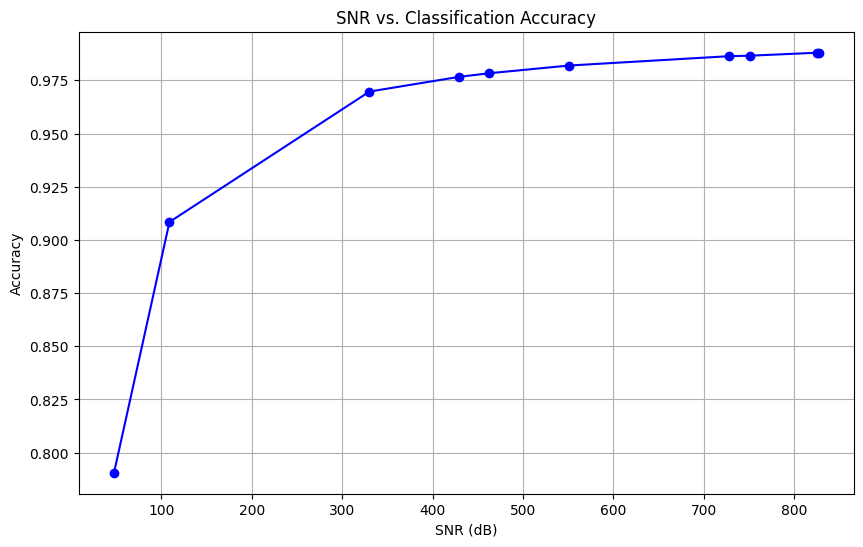

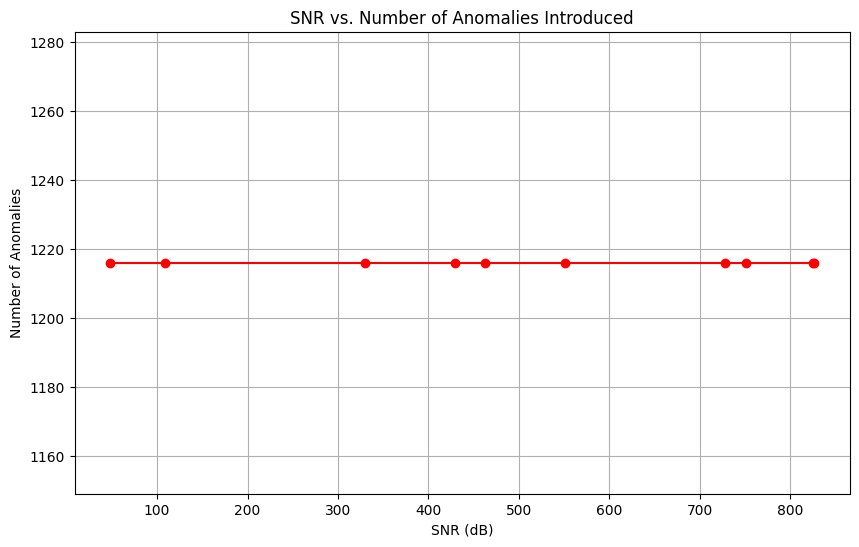

In [3]:
if __name__ == "__main__":
    input_directory = "D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\PMU_Data_with_Anomalies and Events"
    output_directory = "D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\Processed_PMU_Data"
    anomaly_list = [
        {'type': 'drop', 'column': 'Freq', 'start': 100, 'end': 200},
        {'type': 'spike', 'column': 'VA_MAG', 'start': 300, 'end': 350, 'magnitude': 0.5}
    ]

    snr_values = sorted([random.uniform(10, 1000) for _ in range(10)])
    snr_accuracy, snr_anomalies = process_all_files(input_directory, output_directory, snr_values, anomaly_list)

    print("SNR vs Accuracy:", snr_accuracy)
    print("SNR vs Anomalies:", snr_anomalies)

    plot_accuracy_vs_snr(snr_accuracy)
    plot_anomalies_vs_snr(snr_anomalies)


Processing with SNR: 975.8612951689006 dB using DMD
Data loaded successfully from D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\PMU_Data_with_Anomalies and Events\Bus10_Competition_Data.csv. Columns: ['TIMESTAMP', 'BUS10_VA_ANG', 'BUS10_VA_MAG', 'BUS10_VB_ANG', 'BUS10_VB_MAG', 'BUS10_VC_ANG', 'BUS10_VC_MAG', 'BUS10_IA_ANG', 'BUS10_IA_MAG', 'BUS10_IB_ANG', 'BUS10_IB_MAG', 'BUS10_IC_ANG', 'BUS10_IC_MAG', 'BUS10_Freq', 'BUS10_ROCOF', 'Event']
Missing values have been imputed.
DMD-based anomaly detection accuracy at SNR 975.8612951689006: 0.55
Data loaded successfully from D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\PMU_Data_with_Anomalies and Events\Bus19_Competition_Data.csv. Columns: ['TIMESTAMP', 'BUS19_VA_ANG', 'BUS19_VA_MAG', 'BUS19_VB_ANG', 'BUS19_VB_MAG', 'BUS19_VC_ANG', 'BUS19_VC_MAG', 'BUS19_IA_ANG', 'BUS19_IA_MAG', 'BUS19_IB_ANG', 'BUS19_IB_MAG', 'BUS19_IC_ANG', 'BUS19_IC_MAG', 'BUS19_Freq', 'BUS19_ROCOF', 'Event']
Missing values have been impu

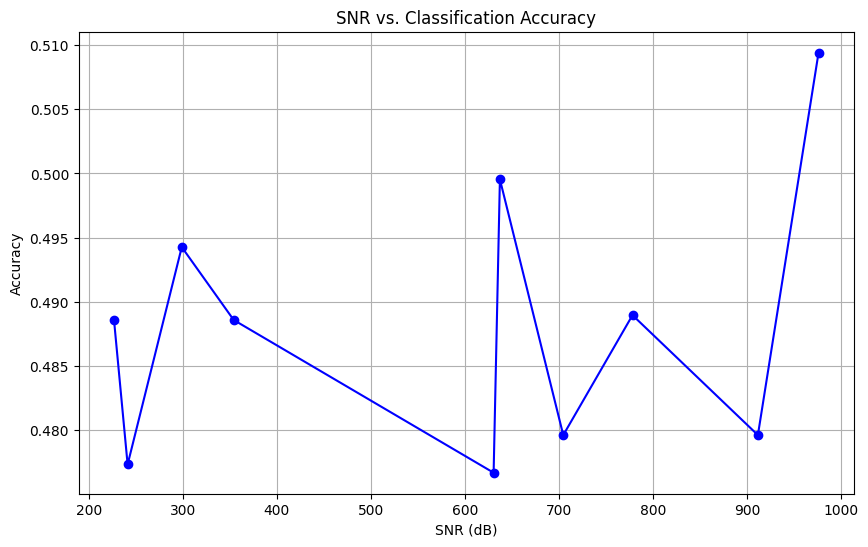

In [4]:
if __name__ == "__main__":
    input_directory = "D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\PMU_Data_with_Anomalies and Events"
    output_directory = "D:\DJT\Downloads\PAPER\PAPER 1\SGSMA_Competiton 2024_PMU_DATA\Processed_PMU_Data"
    anomaly_list = [
        {'type': 'drop', 'column': 'Freq', 'start': 100, 'end': 200},
        {'type': 'spike', 'column': 'VA_MAG', 'start': 300, 'end': 350, 'magnitude': 0.5}
    ]
    snr_values_dmd = sorted([random.uniform(10, 1000) for _ in range(10)], reverse=True)
    snr_accuracy_dmd = process_with_dmd(input_directory, output_directory, snr_values_dmd, anomaly_list)
    print("DMD-Based SNR vs Accuracy:", snr_accuracy_dmd)
    plot_accuracy_vs_snr(snr_accuracy_dmd)